device = cuda

=== L = 12 ===
L=12, z=1.200, <m>=-0.002402
L=12, z=1.227, <m>=-0.006180
L=12, z=1.255, <m>=0.007499
L=12, z=1.282, <m>=-0.006944
L=12, z=1.309, <m>=-0.006720
L=12, z=1.336, <m>=0.007496
L=12, z=1.364, <m>=0.023944
L=12, z=1.391, <m>=0.062063
L=12, z=1.418, <m>=0.101525
L=12, z=1.445, <m>=0.234896
L=12, z=1.473, <m>=0.305928
L=12, z=1.500, <m>=0.399243

=== L = 16 ===
L=16, z=1.200, <m>=0.001273
L=16, z=1.227, <m>=0.007067
L=16, z=1.255, <m>=0.003987
L=16, z=1.282, <m>=-0.001450
L=16, z=1.309, <m>=0.013195
L=16, z=1.336, <m>=0.049409
L=16, z=1.364, <m>=0.079285
L=16, z=1.391, <m>=0.148201
L=16, z=1.418, <m>=0.259473
L=16, z=1.445, <m>=0.397298
L=16, z=1.473, <m>=0.554659
L=16, z=1.500, <m>=0.652712

=== L = 24 ===
L=24, z=1.200, <m>=0.000530
L=24, z=1.227, <m>=0.006596
L=24, z=1.255, <m>=0.001314
L=24, z=1.282, <m>=0.022676
L=24, z=1.309, <m>=0.021511
L=24, z=1.336, <m>=0.068193
L=24, z=1.364, <m>=0.177579
L=24, z=1.391, <m>=0.337434
L=24, z=1.418, <m>=0.489173
L=24, z=1

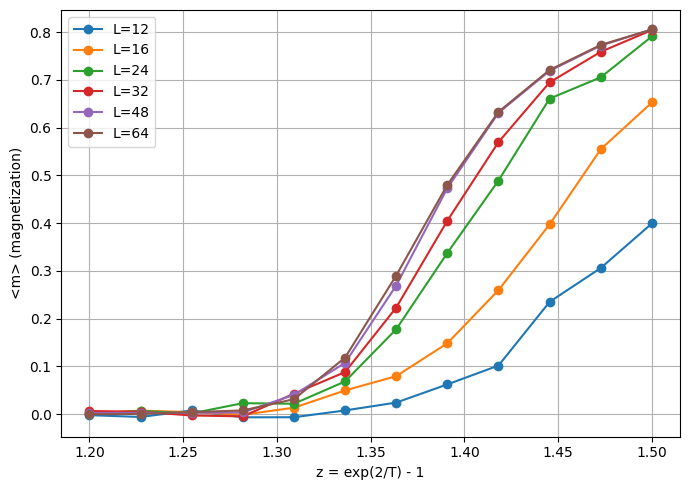

In [9]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

# ----------------------------------------------------------
#  K × N × L × L を同時に回す heat-bath + checkerboard
#  spins: float32, ±1.0
# ----------------------------------------------------------
def sweep_multi_beta(spins, two_betas, iterations, mask_black, mask_white):
    """
    spins      : (K, N, L, L) float32, ±1
    two_betas  : (K, 1, 1, 1) float32, 2*beta
    mask_black : (1, 1, L, L) bool
    mask_white : (1, 1, L, L) bool
    戻り値     : spins, ms (iterations, K, N)
    """
    K, N, L, _ = spins.shape
    ms = torch.empty((iterations, K, N), dtype=torch.float32, device=device)

    for t in range(iterations):
        for mask in (mask_black, mask_white):
            # 近傍和 n = 上下左右
            n  = torch.roll(spins,  1, dims=2)
            n += torch.roll(spins, -1, dims=2)
            n += torch.roll(spins,  1, dims=3)
            n += torch.roll(spins, -1, dims=3)

            # p = sigmoid(2 β n)
            p = torch.sigmoid(two_betas * n)

            # 一様乱数
            r = torch.rand_like(p)

            # 候補値（全格子）
            new_spins = torch.where(r < p, 1.0, -1.0)

            # マスクされた格子だけ更新
            spins = torch.where(mask, new_spins, spins)

        # 各ステップの各系の磁化 (空間平均)
        ms[t] = spins.mean(dim=(3, 2))  # (K, N)

    return spins, ms


# ----------------------------------------------------------
#  1つの L について z_list を同時並列で回す
# ----------------------------------------------------------
def run_for_L(L, z_list, N=1000, iterations=1500, burn_in=500):
    """
    L: system size
    z_list: 温度パラメータ列 (len = K)
    N: 系の数
    iterations: 総 MCS
    burn_in: 捨てるステップ数
    戻り値: (z_array[K], m_expect[K])
    """
    K = len(z_list)

    # z = exp(2/T) - 1 から beta をすべて計算
    betas = []
    for z in z_list:
        T = 2.0 / math.log(z + 1.0)
        betas.append(1.0 / T)
    betas = np.array(betas, dtype=np.float32)

    # two_betas = 2 * beta を tensor にして shape (K,1,1,1)
    two_betas = torch.tensor(2.0 * betas, dtype=torch.float32,
                             device=device).view(K, 1, 1, 1)

    # スピン初期状態: 全て +1.0 (float32)
    spins = torch.ones((K, N, L, L), dtype=torch.float32, device=device)

    # チェッカーボードマスク (1,1,L,L)
    x = torch.arange(L, device=device).view(L, 1)
    y = torch.arange(L, device=device).view(1, L)
    mask2d_black = ((x + y) % 2 == 0)
    mask_black = mask2d_black.view(1, 1, L, L)
    mask_white = (~mask2d_black).view(1, 1, L, L)

    # シミュレーション
    spins, ms = sweep_multi_beta(spins, two_betas, iterations,
                                 mask_black, mask_white)

    # burn-in を捨てて残りで平均 (サンプル数 = (iterations-burn_in) * N)
    ms_eff = ms[burn_in:]                       # (iterations-burn_in, K, N)
    # 時間方向(dim=0) と系方向(dim=2)で平均 → shape = (K,)
    m_expect = ms_eff.mean(dim=0).mean(dim=1).cpu().numpy()

    return np.array(z_list), m_expect


# ----------------------------------------------------------
#  main: L と z を回して <m> を求める & プロット & 数値表示
# ----------------------------------------------------------
def main():
    # システムサイズ
    L_list = [12, 16, 24, 32, 48, 64]

    # z ∈ [1.2, 1.5] を 12 点
    z_list = np.linspace(1.2, 1.5, 12)

    all_results = {}

    for L in L_list:
        print(f"\n=== L = {L} ===")
        z_vals, m_vals = run_for_L(L, z_list,
                                   N=1000, iterations=1500, burn_in=500)
        all_results[L] = (z_vals, m_vals)

        # ここで具体的な値を表示
        for z, m in zip(z_vals, m_vals):
            print(f"L={L:2d}, z={z:.3f}, <m>={m:.6f}")

    # プロット
    plt.figure(figsize=(7, 5))
    for L in L_list:
        z_vals, m_vals = all_results[L]
        plt.plot(z_vals, m_vals, "-o", label=f"L={L}")
    plt.xlabel("z = exp(2/T) - 1")
    plt.ylabel("<m> (magnetization)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_results


# 実行
all_results = main()
